# MACHINE LEARNING I
# 
# LAB ASSIGNMENT II: TIME SERIES

## Authors:

- **Alberto García Martín**: 202309188@alu.comillas.edu

- **Jorge Peralta Fernández-Revuelta**: jperalta@alu.comillas.edu

- **Juan López Segura**: juanls@alu.comillas.edu

In this lab assignment, we will analyze the UnemploymentSpain.dat dataset and extract conclusions, performing several time series methods properly explained.

---

In [1]:
# For more information, check https://www.machinelearningplus.com/time-series/time-series-analysis-python/ 
### Load libraries ###
# interactive plotting
#%matplotlib inline
#%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
sns.set()
#Define figure sizes
plt.rcParams.update({'figure.figsize': (8, 5), 'figure.dpi': 120})

# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from dateutil.parser import parse 

# Machine Learning libraries
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict
import scipy as sp

# Others
import math
from mltools import forecast_tools as FT
import scipy.stats as st

---
## 1. Read the dataset

In [55]:
df

,TOTAL
DATE,
2001-01-01,2017389
2001-02-01,1993273
2001-03-01,1981006
2001-04-01,1910453
2001-05-01,1898285
...,...
2022-06-01,2880582
2022-07-01,2883812
2022-08-01,2924240


In [2]:
# Import data
df = pd.read_csv('UnemploymentSpain.dat', parse_dates=['DATE'], dayfirst=True, sep='\t', index_col='DATE')
df.head()

,TOTAL
DATE,
2001-01-01,2017389
2001-02-01,1993273
2001-03-01,1981006
2001-04-01,1910453
2001-05-01,1898285


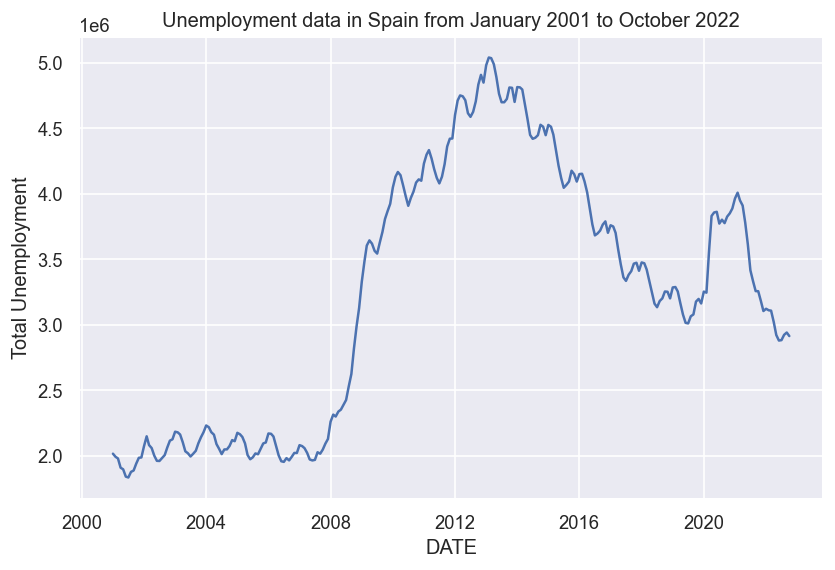

In [117]:
# Plotting a time series
fig, ax = plt.subplots()
ax.plot('TOTAL', data=df)
ax.set(title='Unemployment data in Spain from January 2001 to October 2022', xlabel='DATE', ylabel='Total Unemployment')
plt.show()

---
### Identification process

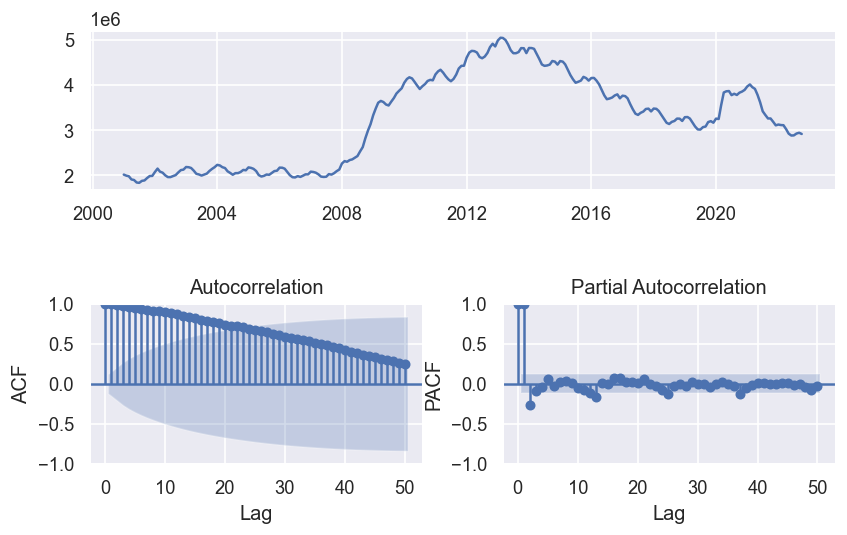

In [4]:
# ACF and PACF of the time series -> identify significant lags and order
FT.ts_display(df,lags=50)

#### 2. Stabilize the variance (if needed)

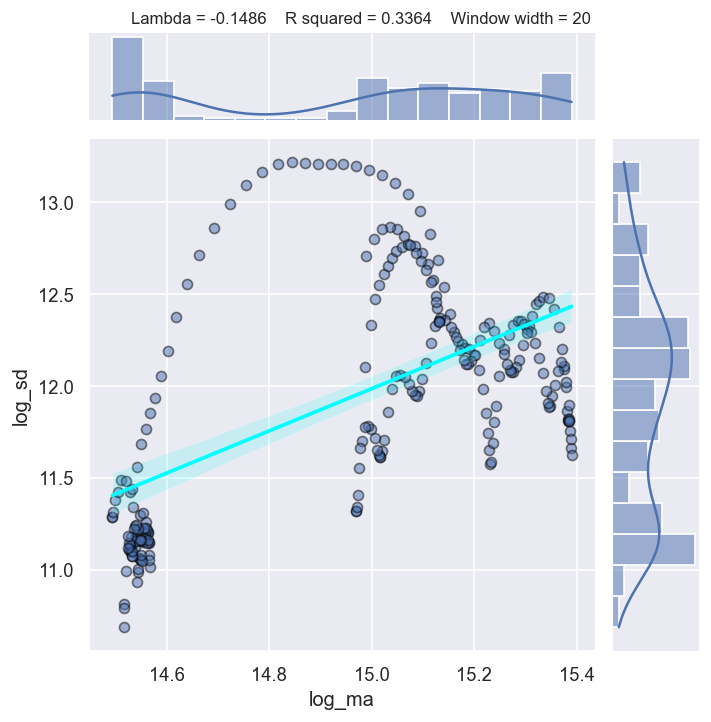

-0.14860691258143222

In [107]:
# Box-Cox transformation
FT.boxcox_lambda_plot(df, window_width=)

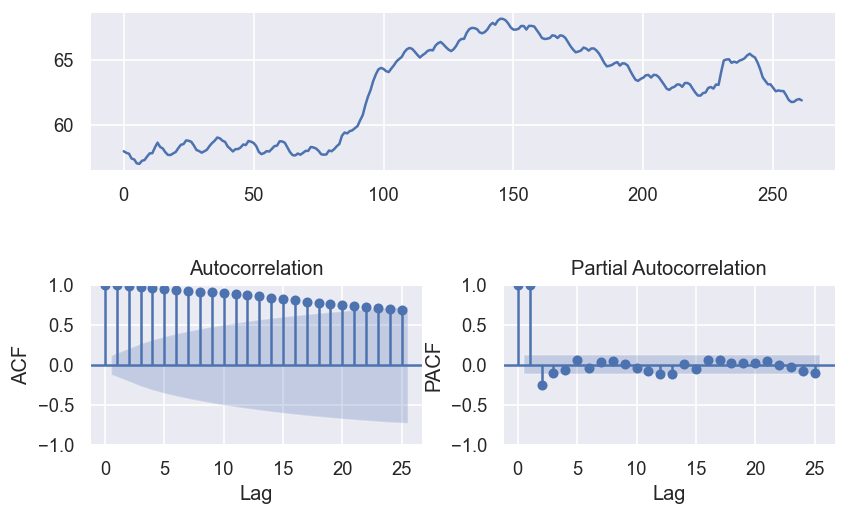

In [67]:
# Compute Box CoxPlot transformed data
BOX_COX = True
if BOX_COX:
    lmbda = 0.1608 #Select lambda
    z = st.boxcox(df.values[:,0],   lmbda = lmbda) #Convert series to positive if neccesary
    #z,lmbda = st.boxcox(df.values[:,0] - min(df.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=df.columns.values.tolist())
else:
    z = df

# Plot transformed data
FT.ts_display(z)

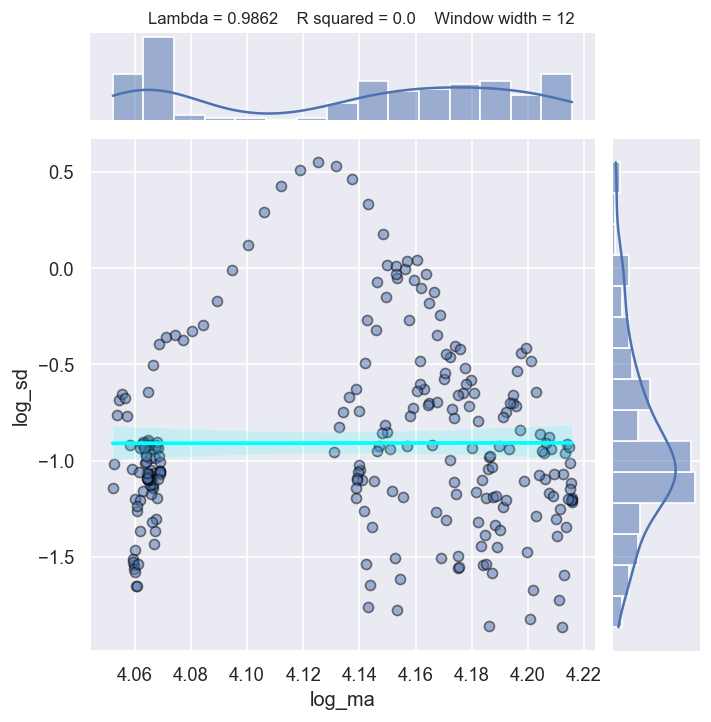

0.9861735104267518

In [70]:
#Check Box Cox of transformed series
FT.boxcox_lambda_plot(z, window_width=12)

#### 3. Analyze stationarity 

In [71]:
# Alternative test - Augmented Dickey Fuller Test
result = adfuller(z.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.644424
p-value: 0.459950
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573


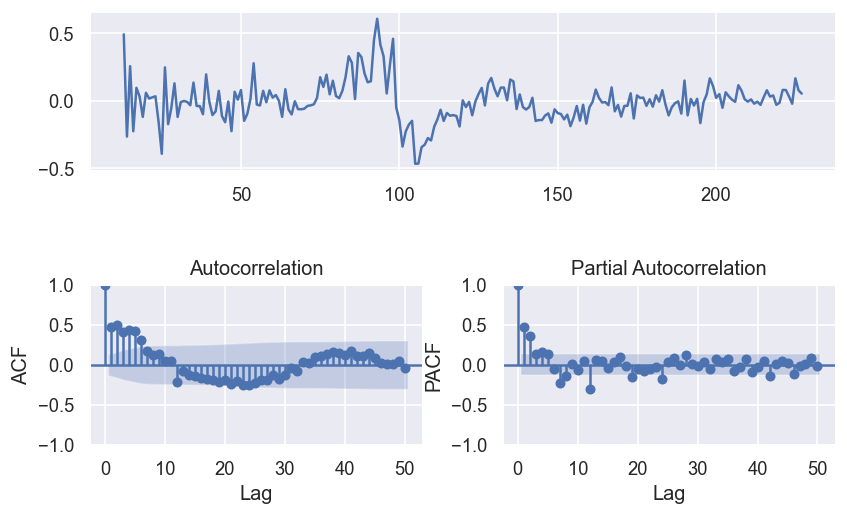

In [100]:
# Difference of the time series
d = 1
D = 1
S = 12 # Seasonality of 12 months

Bz = z
for diff in range(d):
    Bz = Bz.diff().dropna() # drop first NA value
for seas_diff in range(D):
    Bz = Bz.diff(S).dropna() # drop first NA values
FT.ts_display(Bz[:215],lags=50)

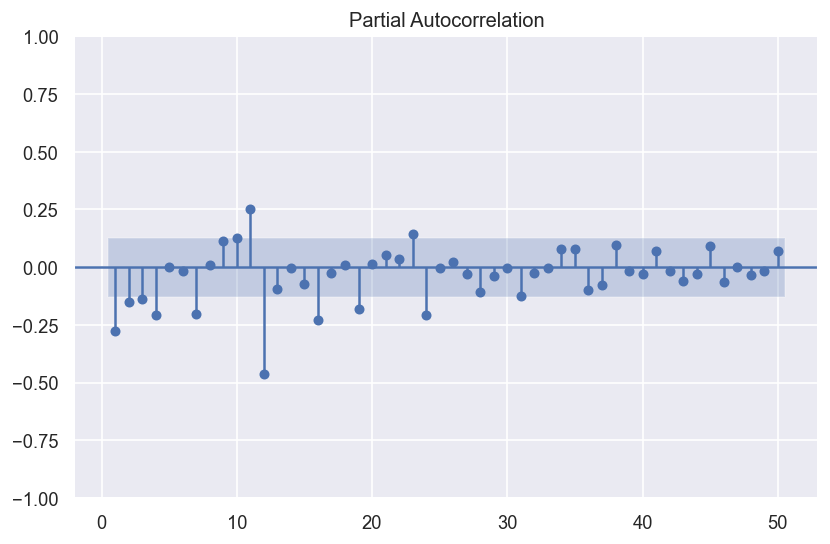

<Figure size 960x600 with 0 Axes>

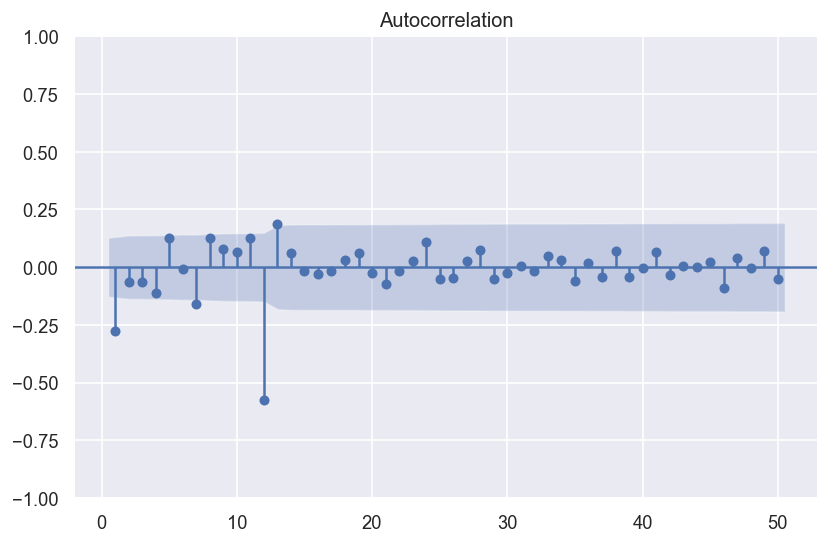

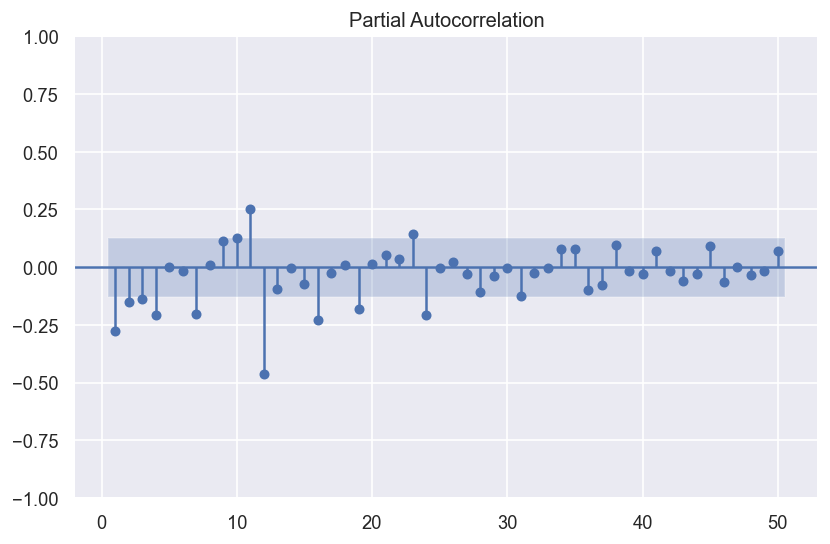

In [83]:
#Bigger plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure()
plot_acf(Bz, lags=50,zero=False)
plot_pacf(Bz, lags=50,zero=False)

It seems necessary an autorregresive model (1,1,0) or an ARMA (1,1,1) for the regular terms, and a mix in the seasonal terms, or a moving average (0,1,1).

In [ ]:
# Define input and output matrices
INPUTS = ['WD','TEMP']
OUTPUT = 'DEM'

# We have categorical inputs with many classes. We will create dummy variables automatically after
X = df[INPUTS]
y = df[OUTPUT]

## Divide the data into training and test sets ---------------------------------------------------
#X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                    test_size=0.2,  #percentage of test data
#                                                    random_state=0) #seed for replication
## Divide the data into training and test sets SEQUENTIALY -------------------------------------
# Create random 80/20 % split
X_train = X.iloc[0:round(0.8*X.shape[0])]
X_test = X.iloc[round(0.8*X.shape[0])+1:X.shape[0]]
y_train = y.iloc[0:round(0.8*X.shape[0])]
y_test = y.iloc[round(0.8*X.shape[0])+1:X.shape[0]]



## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['DEM'] = y_train
dfTS_eval = X_test.copy()
dfTS_eval['DEM'] = y_test

X_train.head()

#### 5. Fit ARIMA model and check significance of the coefficients

In [95]:
# Fit model with estimated order
sarima_fit = SARIMAX(z, 
                    order=(1,1,1), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=True, 
                    enforce_stationarity=True).fit()

print(sarima_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              TOTAL   No. Observations:                  262
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 126.687
Date:                            Sun, 26 Nov 2023   AIC                           -245.374
Time:                                    17:02:58   BIC                           -231.304
Sample:                                         0   HQIC                          -239.711
                                            - 262                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7536      0.053     14.097      0.000       0.649       0.858
ma.L1         -0.1950      0.067   

#### 6. Analyze residuals

Se comienzan los residuos en 20 al ser 262 datos, puesto que si se empieza desde 100 sería casi la mitad del conjunto de datos de los que no se estudian los residuos.

Ljung-Box test of residuals:
      lb_stat  lb_pvalue
25  19.601921   0.767383


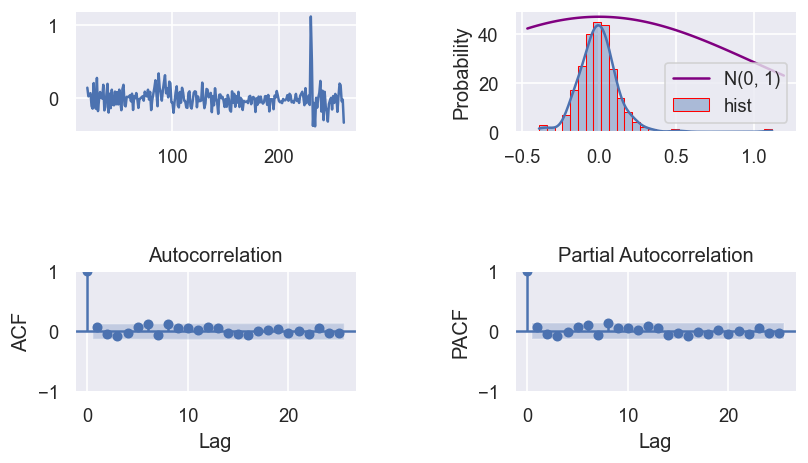

In [97]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarima_fit.resid.loc[20:]))

Este modelo es válido, siendo el mejor en términos de AIC, BIC, relación entre el número de coeficientes y precisión, etc. No obstante, se puede crear otro modelo incluyendo variables no significativas a costa de unos mejores resultados de residuos, debido a que el octavo residuo parece algo significativo en el anterior gráfico. También se observa la necesidad de tratar ese outlier tan extremo de la gráfica.

In [58]:
# Fit model with estimated order
sarima_fit2 = SARIMAX(z, 
                    order=(8,1,0), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=True, 
                    enforce_stationarity=True).fit()

print(sarima_fit2.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                TOTAL   No. Observations:                  262
Model:             SARIMAX(8, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -280.119
Date:                              Sun, 26 Nov 2023   AIC                            580.237
Time:                                      16:54:48   BIC                            615.412
Sample:                                           0   HQIC                           594.395
                                              - 262                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5672      0.031     18.331      0.000       0.507       0.628
ar.L2          0.09

#### 6. Analyze residuals

Ljung-Box test of residuals:
      lb_stat  lb_pvalue
25  10.569181   0.994813


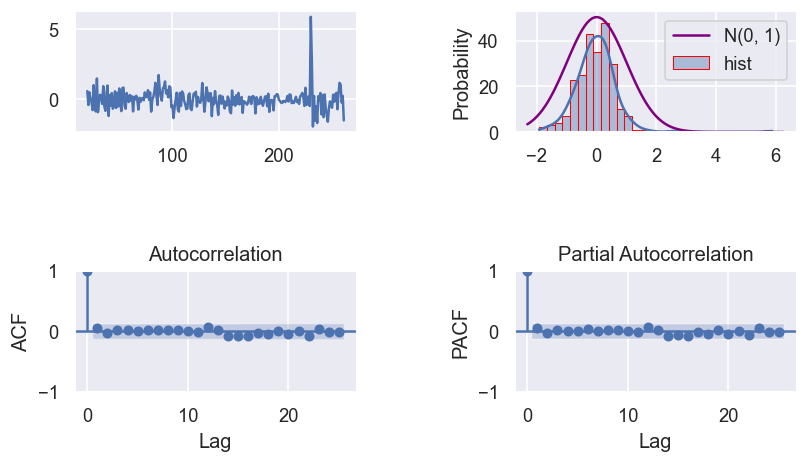

In [59]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarima_fit2.resid.loc[20:]))

Para el outlier: varios

In [118]:
df['Periodo_Covid'] = 0

# Definir el período de COVID-19 (por ejemplo, desde marzo de 2020 hasta la fecha final)
periodo_covid_inicio = pd.to_datetime('2020-03-01')
periodo_covid_fin = pd.to_datetime('2022-07-01')

# Establecer los valores de la columna 'Periodo_Covid' a 1 durante el periodo de COVID-19
df.loc[periodo_covid_inicio:periodo_covid_fin, 'Periodo_Covid'] = 1

In [ ]:
INPUTS_SARMAX = ['COVID']

# We could also fit a more complicated model with ARMA with seasonal components.
mod_sarimax = sm.tsa.SARIMAX(endog = y_train, 
                            order=(1,1,1),
                            seasonal_order=(0,1,1,4),
                            exog = X_train[INPUTS_SARMAX])
res_sarimax = mod_sarimax.fit()

# Show the summary of results
print(res_sarimax.summary())

In [ ]:
# Plot residual error
plt.rcParams.update({'figure.figsize': (8, 5), 'figure.dpi': 120})
FT.check_residuals(pd.DataFrame(res_sarimax.resid),lags=50)